In [ ]:
!pip install python-igraph
!pip install python-igraph leidenalg cairocffi

In [ ]:
import pandas as pd
import numpy as np
import sys
from google.colab import files
import io

In [ ]:
# Read the file
uploaded = files.upload()
my_df = pd.read_csv(io.BytesIO(uploaded['CDOT_Bike_Routes_2014_1216.csv']))
my_df.head()

Saving CDOT_Bike_Routes_2014_1216.csv to CDOT_Bike_Routes_2014_1216.csv


,the_geom,OBJECTID,STREET,PRE_DIR,F_STREET,T_STREET,DISPLAYROU,MI_CTRLINE
0,MULTILINESTRING ((-87.70296713856054 41.771674...,1,MARQUETTE RD,W,S CENTRAL PARK AVE,S KEDZIE AVE,BIKE LANE,0.495170
1,MULTILINESTRING ((-87.69808324194781 41.771749...,2,MARQUETTE RD,W,S KEDZIE AVE,S SACRAMENTO AVE,SHARED-LANE,0.252403
2,MULTILINESTRING ((-87.6613198571441 41.8578756...,3,18TH ST,W,S DAMEN AVE,S LOOMIS ST,BIKE LANE,0.757321
3,MULTILINESTRING ((-87.54056320645704 41.748437...,4,LAKE SHORE DR,S,E 81ST ST,E 87TH ST,BUFFERED BIKE LANE,0.754309
4,MULTILINESTRING ((-87.67673906927449 41.884982...,5,LAKE ST,W,N KEDZIE AVE,N DAMEN AVE,PROTECTED BIKE LANE,1.522768


In [ ]:
import igraph as ig
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.linear_model import LinearRegression

In [ ]:
DF= my_df.loc[:,["F_STREET","T_STREET"]]
g = ig.Graph.TupleList([tuple(x) for x in DF.values], directed=False)

In [ ]:
DF.head()

,F_STREET,T_STREET
0,S CENTRAL PARK AVE,S KEDZIE AVE
1,S KEDZIE AVE,S SACRAMENTO AVE
2,S DAMEN AVE,S LOOMIS ST
3,E 81ST ST,E 87TH ST
4,N KEDZIE AVE,N DAMEN AVE


In [ ]:
#g = g.simplify(multiple=False)
print(g.vcount(),'nodes and',g.ecount(),'undirected edges')


530 nodes and 883 undirected edges


In [ ]:
## read vertex attributes and add to graph
lookup = {k:v for v,k in enumerate(''+my_df['PRE_DIR'] +' '+ my_df['STREET'])}


In [ ]:
## define colors and node sizes here
cls_edges = ['black','cadetblue','aliceblue','aquamarine', 'gainsboro']
cls = ['silver','dimgray','black']
sz = [0.5,6,9,12]

In [ ]:
def parseMultiString(multiLine):
  multiLine = multiLine.replace('MULTILINESTRING ','')
  multiLine = multiLine.replace('((','')
  multiLine = multiLine.replace('))','')
  multiLine = multiLine.replace(')','')
  multiLine = multiLine.replace('(','')
  #print(multiLine)
  array = str(multiLine).split(', ')
  list=[]
  for x in array:
    splitarray = x.split(' ')
    list.append(splitarray)
  return list

def colorCodes(bikeLane, g):
  if bikeLane == 'PROTECTED BIKE LANE':
    #print('PROTECTED BIKE LANE')
    g.vs()['color'] = cls[0]
    g.es()['color'] = cls_edges[4]
  elif bikeLane == 'BIKE LANE':
    #print('BIKE LANE')
    g.vs()['color'] = cls[0]
    g.es()['color'] = cls_edges[4]
  elif bikeLane == 'BUFFERED BIKE LANE':
    #print('BUFFERED BIKE LANE')
    g.vs()['color'] = cls[0]
    g.es()['color'] = cls_edges[4]
  elif bikeLane == 'SHARED-LANE':
    #print('SHARED LANE')
    g.vs()['color'] = cls[2]
    g.es()['color'] = cls_edges[4]
  elif bikeLane == 'NEIGHBORHOOD GREENWAY':
    #print('NEIGHBORHOOD GREENWAY')
    g.vs()['color'] = cls[1]
    g.es()['color'] = cls_edges[4]
  else:
    g.vs()['color'] = cls[0]
    g.es()['color'] = cls_edges[4]

def plotRoutes(iterRows, g):
  #print(iterRows)
  list = parseMultiString(iterRows[0])
  g = g.simplify(multiple=False)
  g.vs()['layout'] = [(float(index[0]), float(index[1])) for index in list]
  g.vs()['size'] = sz[0]
  g.es()['arrow_size'] = 0.0
  # call color combination function
  colorCodes(iterRows[3],g)

l= my_df.loc[:,["the_geom","F_STREET","T_STREET","DISPLAYROU"]]

for row in l.itertuples(index=False):
  plotRoutes(row,g) 
## plot using lat/lon as layout
ly = ig.Layout(g.vs['layout'])
ly.mirror(0)
g = g.simplify(multiple=False)


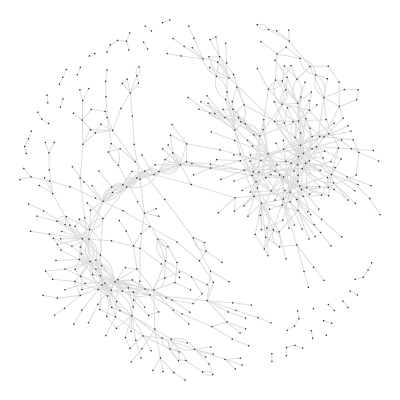

In [ ]:
ig.plot(g, bbox=(0,0,400,400), mark_groups = True )

***END***

In [ ]:
# undirected
def deg_corr(G):
    idx = {v:k for k,v in enumerate([i for i in set(G.degree())])}
    idx_inv = {k:v for k,v in enumerate(idx)}
    deg = G.degree()
    L = [[] for i in range(len(idx))]
    for v in G.vs():
        # w = [deg[i] for i in list(set(G.neighbors(v)))] 
        w = [deg[i] for i in G.neighbors(v)] 
        L[idx[v.degree()]].extend(w)
    return {idx_inv[i]:np.mean(L[i]) for i in range(len(L))}


## Correlation exponent via linear regression (taking logs)
def corr_exp(G):
    ## compute knn's
    knn = deg_corr(G)
    # Fit the regression
    regressor = LinearRegression()  
    x = [np.log(i) for i in knn.keys()]
    y = [np.log(i) for i in knn.values()]
    regressor.fit(np.array(x).reshape(-1,1), y)
    return regressor.coef_[0]

## degree correlation for neutral graphs: <k^2>/<k>
def deg_corr_neutral(G, mode='all'):
    x = G.degree(mode=mode)
    return np.mean([i**2 for i in x])/np.mean(x)    

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


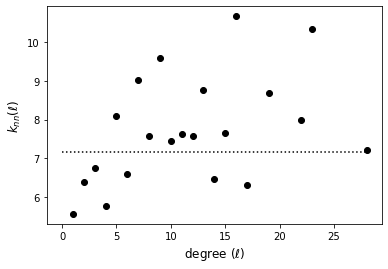

In [ ]:
knn = deg_corr(g)
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_neutral(g)
plt.scatter(x,y,c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);

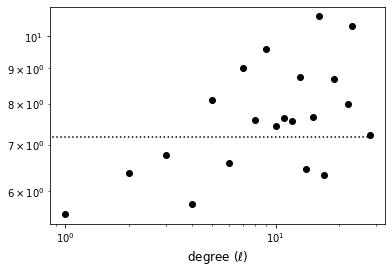

In [ ]:
plt.loglog(x,y,'o',c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12);

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


r = 0.12908137137189524


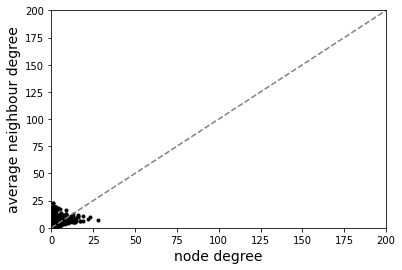

In [ ]:
## plot degree vs avg neighbour degree
deg = [v.degree() for v in g.vs()]
nad = []
for v in g.vs():
    nv = g.neighbors(v)
    nad.append(np.mean([deg[i] for i in nv]))

plt.scatter(deg,nad,c='black',marker='.')
plt.xlim((0,200))
plt.ylim((0,200))
plt.xlabel('node degree', fontsize=14)
plt.ylabel('average neighbour degree', fontsize=14);
plt.plot([0,200],[0,200],'--', c='gray')
print('r =',g.assortativity_degree());

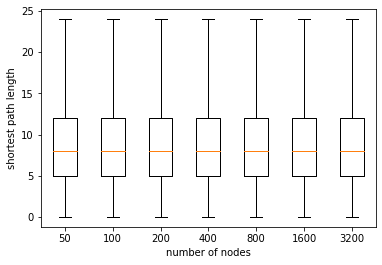

In [ ]:
sp = []
N = [50,100,200,400,800,1600,3200]
for n in N:
    p = 5/(n-1)
    ## keep giant component
    g = g.clusters().giant()
    z = g.shortest_paths()
    sp.append([x for y in z for x in y])
## plot    
plt.boxplot(sp, labels=N, sym='.',whis=5)
plt.ylabel('shortest path length')
plt.xlabel('number of nodes');


In [ ]:
g.vs['comm'] = [0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1]
def push_layout(d=0):
    if np.max(g.vs['comm'])>2:
        return -1
    ly = g.layout()
    g.vs['ly'] = ly
    x = [0,0,0]
    y = [0,0,0]
    for v in g.vs:
        c = v['comm']
        x[c] += v['ly'][0]
        y[c] += v['ly'][1]
    delta = [-d,0,d]
    dx = [delta[i] for i in np.argsort(x)]
    dy = [delta[i] for i in np.argsort(y)]
    for v in g.vs:
        c = v['comm']
        v['ly'][0] += dx[c]
        v['ly'][1] += dy[c]
    return g.vs['ly']

In [ ]:
print('max degree', g.maxdegree())
print(g.vcount(),'nodes and',g.ecount(),'undirected edges')

max degree 28
474 nodes and 839 undirected edges


In [ ]:
degrees = []
total = 0

for n in range(g.vcount()):
    neighbours = g.neighbors(n, mode='ALL')
    total += len(neighbours)
    degrees.append(len(neighbours))
vMax=degrees.index(max(degrees))    
vMin=degrees.index(min(degrees))
print("Maximum degree:", max(degrees),"Vertex ID with the maximum degree:", vMax)
print("Minimum degree:", min(degrees),"Vertex ID with the minimum degree:", vMin)

Maximum degree: 28 Vertex ID with the maximum degree: 152
Minimum degree: 1 Vertex ID with the minimum degree: 6


In [ ]:
## undirected degree centrality
def degree_centrality(g):
    n = g.vcount()
    if g.is_directed():
        dc = [sum(x)/(2*(n-1)) for x in zip(g.strength(mode='in'),\
              g.strength(mode='out'))]
    else:
        dc = [x/(n-1) for x in g.strength()]
    return dc

## compute several centrality measures
C = pd.DataFrame({'station':g.vs()['name'],\
                  'degree':degree_centrality(g),})

## sort w.r.t. degree centrality, look at top stations
df = C.sort_values(by='degree', ascending=False)
df.head()


,station,degree
152,S STATE ST,0.059197
8,N DAMEN AVE,0.048626
130,S HALSTED ST,0.046512
68,W LAKE ST,0.040169
65,N WESTERN AVE,0.040169


299 nodes


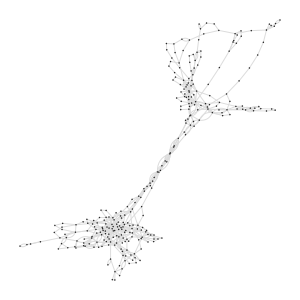

In [ ]:

sg = g.subgraph([i for i in g.neighborhood(vMax,order=28)])
sg.vs()['core'] = sg.coreness()
sg.delete_vertices([v for v in sg.vs if v['core']<2])
print(sg.vcount(),'nodes')
ig.plot(sg,bbox=(0,0,300,300))

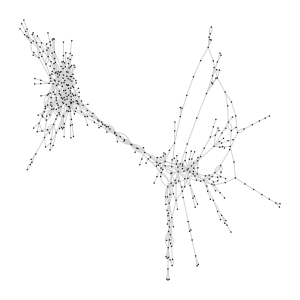

In [ ]:
g.vs['color'] = [cls[i] for i in g.vs['comm']]
g.vs['size'] = sz[0]
g.es['color'] = 'lightgrey'
ig.plot(g, bbox=(0,0,300,300))

r = 0.09610671351979526 mu = 0.07893721506166489 P(edges above structural cutoff) = 0.0


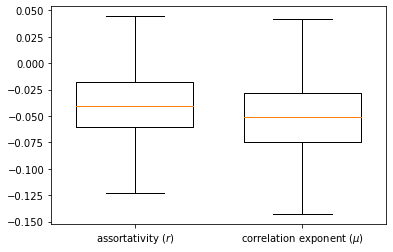

In [ ]:
## compare r and mu vs random models for the Dakotas: G = SD+ND
## here we use the configuration model from Viger and Latapy
## we alse report the proportion of nodes above the structural cutoff
## given the degree distribution.
r = []
mu = []
for i in range(1000):    
    cm = ig.Graph.Degree_Sequence(g.degree(),method="vl")
    r.append(cm.assortativity_degree())
    mu.append(corr_exp(cm))
## structural cutoff
sc = np.sqrt(2*g.ecount())
p = len([x for x in g.degree() if x > sc])/g.vcount()
print('r =',g.assortativity_degree(),'mu =',corr_exp(g),'P(edges above structural cutoff) =', p)
plt.boxplot([r,mu],labels=[r'assortativity ($r$)',r'correlation exponent ($\mu$)'],widths=.7,sym='');

In [ ]:
print(g.vcount(),'nodes and',g.ecount(),'undirected edges')
print(g.is_connected())
print(g.is_directed())

474 nodes and 839 undirected edges
True
False


Total Clusters Found is 3. Divided nodes into three clusters

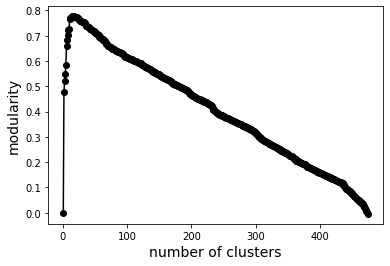

In [ ]:
## compute modularity at each possible cut
gn = g.community_edge_betweenness()
q = []
for i in np.arange(g.vcount()):
    q.append(g.modularity(gn.as_clustering(n=i+1)))
plt.plot(np.arange(1,1+g.vcount()),q,'o-',color='black')
plt.xlabel('number of clusters',fontsize=14)
plt.ylabel('modularity',fontsize=14);

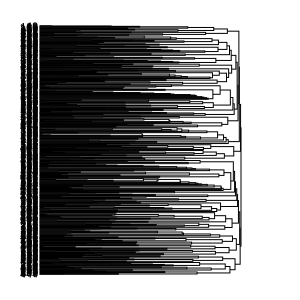

In [ ]:
ig.plot(gn,bbox=(0,0,300,300))

AMI: 0.002821636437246742
q: 0.5199049325137338


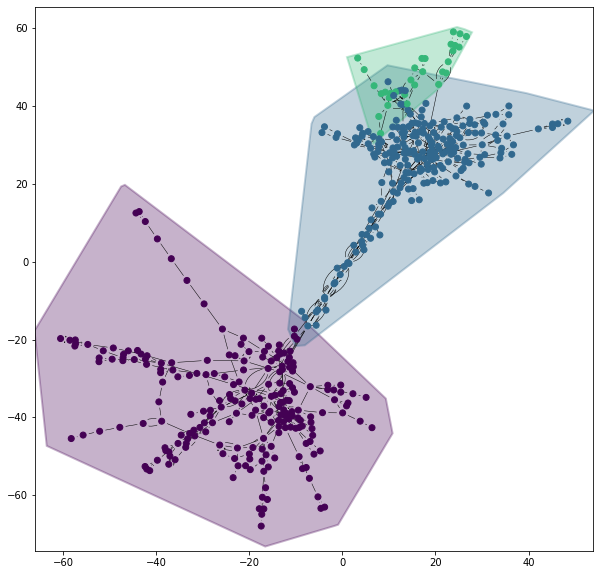

In [ ]:
from sklearn.metrics import adjusted_mutual_info_score as AMI
from copy import deepcopy
visual_style = {}
gc = g.copy()
## show result with optimal modularity (3 clusters)
communities = gn.as_clustering(n=3)
membership = communities.membership
gc.vs['label'] = membership
print('AMI:',AMI(gc.vs['comm'],gc.vs['label']))
print('q:',gc.modularity(gc.vs['label']))
gc.es['color'] = 'lightgrey'


# Set community colors
num_communities = len(communities)
palette1 = ig.RainbowPalette(n=num_communities)
for i, community in enumerate(communities):
    gc.vs[community]["color"] = i
    community_edges = gc.es.select(_within=community)
    community_edges["color"] = i

# Plot the communities
fig1, ax1 = plt.subplots()
fig1.set_size_inches(10, 10)
ig.plot(
    communities,
    target=ax1,
    mark_groups=True,
    palette=palette1,
    vertex_size=sz[1],
    edge_width=0.5,
    margin=10
)

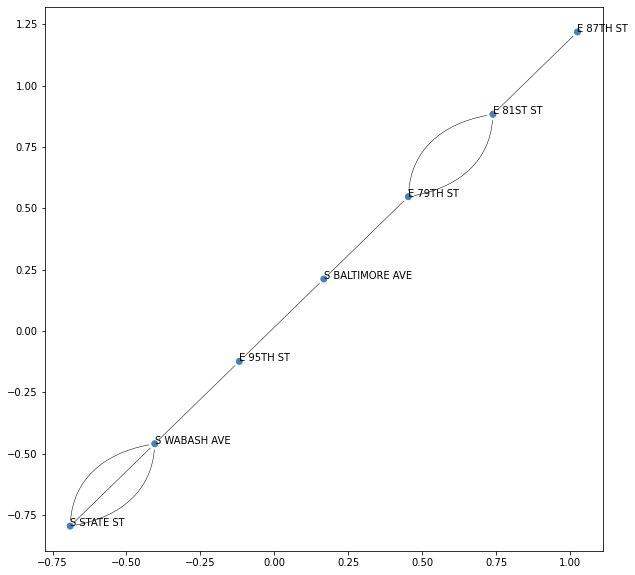

In [ ]:
[vertices, layers, parents] = g.bfs(vMin, mode='OUT')

#Shortest Path from min degree node to max degree node
[vertices] = g.get_shortest_paths(vMin, vMax)
G= g.subgraph(vertices)

G.es()['arrow_size'] = 0.5
fig1, ax1 = plt.subplots()
fig1.set_size_inches(10, 10)
ig.plot(
    G,
    target=ax1,
    vertex_label = G.vs()['name'],
    vertex_size=sz[1],
    edge_width=0.5,
    margin=10
)



In [ ]:
edge_df = pd.DataFrame({attr: G.es[attr] for attr in G.edge_attributes()})
node_df = pd.DataFrame({attr: G.vs[attr] for attr in G.vertex_attributes()})
print(G.vcount(),'nodes and',G.ecount(),'undirected edges')



7 nodes and 9 undirected edges
